## Setup

In [25]:
import warnings
warnings.filterwarnings("ignore")

import os
import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import preprocessing as preprocess
import grouping as group
import spliting as split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import font_manager
plt.rcParams['axes.unicode_minus'] = False
# plt.figure(figsize=(10, 5))

import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

# font_path = 'C:\\Windows\\Fonts\\NanumBarunGothicUltraLight.ttf' #한글 폰트 경로 
font_path = 'C:\\Windows\\Fonts\\malgun.ttf' #한글 폰트 경로 

font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [26]:
#MAPE definition
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Data Load and Preprocessing

`preprocessing.py`와 `grouping.py`에 전처리 코드를 넣어 원본데이터가 한번에 전처리되어 출력되도록 했습니다. 주요 전처리 내용은 다음과 같습니다. <br><br>

**1. 종속변수(취급액) 가공**

예측의 대상인 취급액은 판매단가에 판매량을 곱한 값으로 상품마다 scale의 차이가 큽니다. 따라서 취급액을 판매단가로 나눈 판매량이라는 변수를 새로 만들어 이를 예측하는 것이 유리합니다. 그리고 판매량의 분포가 양의 왜도를 가짐을 확인하고 이를 정규화하기 위해 로그 변환을 해주어 `log_sales_cnt`라는 변수를 생성했습니다.

**2. 파생변수 생성**

제공된 데이터의 변수는 8개입니다. 좋은 성능의 모델을 만들기 위해서는 유의미한 변수의 도출이 필수적입니다. EDA를 통해 변수의 특성을 파악하고 FE를 진행했습니다. 방송일시 변수를 연, 월, 일, 시, 분, 요일 등으로 나누고 공휴일 변수를 추가했습니다. 이외에도 다양한 변수를 가공해 `order_grp`나 `unit_price_group`등의 변수를 생성했습니다.

**3. 외부변수 채택**

주어진 변수 이외에도 판매량에 영향을 미칠 수 있는 외부변수를 채택했습니다. [기상자료개방포털](https://data.kma.go.kr/cmmn/main.do)에서 시각별 기온, 강수량, 습도 등의 기상정보를 가져왔고 [통계청](http://kostat.go.kr/portal/korea/index.action)에서 소비자 물가지수와 소비자 동향지수 데이터를 가져왔습니다. 이외에도 검색어 데이터, 뉴스 데이터도 고려했으나 양질의 데이터 획득의 어려움과 비상관성을 이유로 채택하지 않았습니다.

In [27]:
""""Directory
bigcon 
  |- data
       |- 01_제공데이터
       |- 02_평가데이터
  |- source
"""
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'data')
source_dir = os.path.join(cur_dir, 'source')
data_train_dir = os.path.join(data_dir, '01_제공데이터')
data_test_dir = os.path.join(data_dir, '02_평가데이터')


""" Parameters
"""
headline = '2020 빅콘테스트 데이터분석분야-챔피언리그'
train_target = '2019년 실적데이터'
test_target = '2020년 6월 판매실적예측데이터(평가데이터)'
rate_target = '시청률 데이터'


""" Load Data
"""
dfs = preprocess.ProcessSale(
    data_dir = data_dir,
    source_dir = source_dir,
    data_train_dir = data_train_dir,
    data_test_dir = data_test_dir,
    headline = headline,
    train_target = train_target,
    rate_target = rate_target,
    test_target = test_target,
)

df_train = dfs.train_preprocess()
df_test = dfs.test_preprocess()
df_rate = dfs.rate_preprocess()

Grouping = group.Grouping(df_train, df_test)
df_train = Grouping.make_train()
df_test = Grouping.make_test()

Train : file already exist!
Test : file already exist!


In [28]:
print(df_train.shape) #제공데이터
print(df_test.shape)  #평가데이터

(35379, 32)
(2716, 32)


최종적으로, 전처리 된 컬럼은 다음과 같습니다.

#### 기존변수
  * **datetime** - 방송일시입니다.
  * **exposure(min)** - 상품이 방송에 노출된 시간입니다.
  * **mother_cd** - 상품의 마더코드입니다.
  * **product_cd** - 상품의 상품코드입니다.
  * **product_name** - 상품명입니다.
  * **product_grp** - 상품군입니다.
  * **unit_price** - 상품의 개당 판매단가입니다. 
  * **sell_price** - 상품의 총 판매액, 즉 취급액입니다.
 
#### 파생변수
  * **sales_cnt** -  판매량입니다. 상품의 취급액을 판매단가로 나누어 계산합니다.
  * **log_sales_cnt** -  판매량에 로그를 취한 값입니다. 종속변수의 분포를 정규화하기 위함입니다.
  * **group** - 판매량과 판매단가의 특성을 고려해 설정한 상품의 그룹입니다. 추후 해당 그룹별로 모델링을 진행합니다.
  * **unit_price_group** - 각 그룹별 판매단가의 정도입니다. 각 그룹 기준 33% 미만은 chaep, 33%이상 66%미만은 medium, 나머지는 expensive입니다.
  
  * **year** - 방송일시에서 파생된 변수입니다. 방송된 연도입니다. 
  * **month** - 방송일시에서 파생된 변수입니다. 방송된 월입니다
  * **day** - 방송일시에서 파생된 변수입니다. 방송된 일자입니다
  * **hour** - 방송일시에서 파생된 변수입니다. 방송된 시각입니다
  * **minute** - 방송일시에서 파생된 변수입니다. 방송된 분입니다
  * **weekday** - 방송일시에서 파생된 변수입니다. 방송된 요일입니다
  * **holiday** - 공휴일입니다. 2019년 및 2020년 법정공휴일과 주말은 1, 나머지는 0입니다.
  * **month_order** - 월초, 월중, 월말을 나타내는 변수입니다. 
  * **order_grp** - 같은 상품이 연속적으로 방송되었을 경우의 순서정보입니다. 방송일시와 마더코드를 기준으로 생성했습니다. 시작, 중간, 마지막으로 이루어져있습니다.
  
#### 외부변수
  * **temp** - 방송된 시각의 기온(°C)입니다. 
  * **rainfall** - 방송된 시각의 강수량(mm)입니다. 
  * **wind_speed** - 방송된 시각의 풍속(m/s)입니다.
  * **wind_direction** - 방송된 시각의 풍향(16방위)입니다.
  * **humidity** - 방송된 시각의 습도(%)입니다.
  * **pressure** - 방송된 시각의 증기압(hPa)입니다.
  * **spot_pressure** - 방송된 시각의 현지기압(hPa)입니다..
  * **sea_level_pressure** - 방송된 시각의 해면기압(hPa)입니다.
  * **snowfall** - 방송된 시각의 적설량(cm)입니다.
  
  * **cpi** - 방송된 월의 소비자 물가지수입니다.
  * **csi** - 방송된 월의 소비자 동향지수입니다.
  
  
#### 외부변수 출처
기상자료개방포털 : [https://data.kma.go.kr/cmmn/main.do](https://data.kma.go.kr/cmmn/main.do)<br>
통계청 : [http://kostat.go.kr/portal/korea/index.action](http://kostat.go.kr/portal/korea/index.action)

In [29]:
df_train.head()

,datetime,year,month,day,hour,minute,weekday,holiday,month_order,order_grp,exposure(min),mother_cd,product_cd,product_name,product_grp,temp,rainfall,wind_speed,wind_direction,humidity,pressure,spot_pressure,sea_level_pressure,snowfall,unit_price,sell_price,sales_cnt,group,unit_price_group,cpi,csi,log_sales_cnt
0,2019-01-01 06:00:00,2019,1,1,6,0,Tuesday,1,초,시작,20.0,100346,201072,테이트 남성 셀린니트3종,의류,-7.9,0.0,1.3,290.0,60.0,2.0,1023.6,1034.9,0.0,39900.0,2099000.0,52.606516,group4,cheap,100.8,97.5,3.962840
1,2019-01-01 06:00:00,2019,1,1,6,0,Tuesday,1,초,시작,20.0,100346,201079,테이트 여성 셀린니트3종,의류,-7.9,0.0,1.3,290.0,60.0,2.0,1023.6,1034.9,0.0,39900.0,4371000.0,109.548872,group4,cheap,100.8,97.5,4.696371
2,2019-01-01 06:20:00,2019,1,1,6,20,Tuesday,1,초,중간,20.0,100346,201072,테이트 남성 셀린니트3종,의류,-7.9,0.0,1.3,290.0,60.0,2.0,1023.6,1034.9,0.0,39900.0,3262000.0,81.754386,group4,cheap,100.8,97.5,4.403719
3,2019-01-01 06:20:00,2019,1,1,6,20,Tuesday,1,초,중간,20.0,100346,201079,테이트 여성 셀린니트3종,의류,-7.9,0.0,1.3,290.0,60.0,2.0,1023.6,1034.9,0.0,39900.0,6955000.0,174.310777,group4,cheap,100.8,97.5,5.160840
4,2019-01-01 06:40:00,2019,1,1,6,40,Tuesday,1,초,마지막,20.0,100346,201072,테이트 남성 셀린니트3종,의류,-7.9,0.0,1.3,290.0,60.0,2.0,1023.6,1034.9,0.0,39900.0,6672000.0,167.218045,group4,cheap,100.8,97.5,5.119299


## EDA

변수별 EDA 자료와 코드는 첨부된 ipynb파일에 있으며, 주요 내용은 결과보고서에 시각화 자료를 첨부합니다.
* EDA_weather.ipynb
* EDA_basic.ipynb
* EDA_other.ipynb

## Variable Selection and Grouping
변수선택과 Grouping, 범주형변수 더미화는 `spliting.py`로 처리했습니다. 해당 클래스의 `return_g`라는 함수는 전처리된 데이터프레임 `df_train`을 받아 정해진 변수에 대해 Grouping과 더미화를 하고 네 개의 데이터프레임을 출력합니다.

#### Variable Selection
EDA를 통해 선택된 유의미한 변수는 다음과 같습니다.

`month`, `hour`, `minute`, `weekday`, `holiday`, `month_order`, `order_grp`, `exposure(min)`, `mother_cd`, `product_cd`, `product_grp`, `temp`, `rainfall`, `humidity`, `snowfall`, `wind_speed`, `unit_price`, `unit_price_group`, `cpi`, `csi`  

학습에 사용될 종속변수는 `log_sales_cnt`입니다.

#### Grouping
그룹은 모델의 성능 상승을 위해 생성했습니다. 상품군 별 판매량과 판매단가의 분포를 확인하고 각 상품군 간 상관관계를 고려하여 그룹을 만들었습니다. 해당 그룹별로 약간의 변수 조정이 있을 수 있으며 추후 다른 모델이 각각 적용될 수 있습니다.
 * Group 1 : 가구 가전<br>
 * Group 2 : 농수축, 이미용<br>
 * Group 3 : 생활용품, 주방, 잡화<br>
 * Group 4 : 건강기능, 속옷, 의류, 침구<br><br>
 
그룹 구성에 관련한 분포 시각화 및 상관관계 정보는 별도의 파일로 첨부합니다.
 * Grouping.ipynb(규형)

In [30]:
Spliting = split.Spliting()
g1, g2, g3, g4 = Spliting.return_g(df_train)

In [31]:
print(g1.shape) #group1
print(g2.shape) #group2
print(g3.shape) #group3
print(g4.shape) #group4

(7465, 30)
(5189, 17)
(13034, 17)
(9691, 17)


## Train Test Split
각 그룹별 모델링을 진행하기 위해 X와 y로 변수를 나눠주고, 각각을 Train Set과 Test Set으로 나눠줍니다.

In [32]:
X1, y1 = g1.drop('log_sales_cnt', axis=1), g1['log_sales_cnt']
X2, y2 = g2.drop('log_sales_cnt', axis=1), g2['log_sales_cnt']
X3, y3 = g3.drop('log_sales_cnt', axis=1), g3['log_sales_cnt']
X4, y4 = g4.drop('log_sales_cnt', axis=1), g4['log_sales_cnt']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=42)

In [33]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=42)

In [34]:
print(X1_train.shape, y1_train.shape, X1_test.shape, y1_test.shape)
print(X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape)
print(X3_train.shape, y3_train.shape, X3_test.shape, y3_test.shape)
print(X4_train.shape, y4_train.shape, X4_test.shape, y4_test.shape)

(5225, 29) (5225,) (2240, 29) (2240,)
(3632, 16) (3632,) (1557, 16) (1557,)
(9123, 16) (9123,) (3911, 16) (3911,)
(6783, 16) (6783,) (2908, 16) (2908,)


## Modeling
모델링은 각 그룹별로 여러 개의 머신러닝 및 딥러닝 기법을 시도하여 Best Score를 갖는 모델을 채택했습니다.<br><br>
시도한 모델은 다음과 같습니다.

 * Linear Regression
 * Ridge/Lasso Regression
 * Support Vector Regression
 * Decesion Tree
 * RandomForest
 * XGBoost
 * LightGBM
 * CatBoost
 * LSTM/GRU
 
<br>
위의 모델을 모두 적합하여 Competition을 시도하고, Best Model에 대해서 Parameter Tuning을 진행합니다.모델  Parameter Tuning은 Scikit-learn의 `GridSearchCV`를 사용합니다.

<br>

**최종적으로 선택된 모델은 Group1은 CatBoost, 나머지 그룹은 LightGBM입니다.**

### Group 1
group1에서는 product_name을 기반으로 상품의 정보를 가진 범주형자료를 추가로 생성했습니다. (`spliting.py` 참조) 

In [35]:
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn import metrics

In [36]:
col = ['month','weekday','month_order','order_grp','product_grp','unit_price_group']

In [37]:
for i in col : 
    X1_train[i] = X1_train[i].astype('category') 
    X1_test[i] = X1_test[i].astype('category')

In [38]:
X1_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5225 entries, 13616 to 33582
Data columns (total 29 columns):
month               5225 non-null category
hour                5225 non-null int64
minute              5225 non-null int64
weekday             5225 non-null category
holiday             5225 non-null int64
month_order         5225 non-null category
order_grp           5225 non-null category
exposure(min)       5225 non-null float64
mother_cd           5225 non-null int64
product_grp         5225 non-null category
temp                5225 non-null float64
humidity            5225 non-null float64
unit_price          5225 non-null float64
unit_price_group    5225 non-null category
cpi                 5225 non-null float64
csi                 5225 non-null float64
installment         5225 non-null bool
samsung             5225 non-null bool
lg                  5225 non-null bool
washer              5225 non-null bool
refrigerator        5225 non-null bool
laptop              522

In [39]:
def model1_mape(num_leaves, learning_rate, n_estimators, max_depth, min_child_samples,bagging_freq):
    model1 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = int(num_leaves), 
                              learning_rate = learning_rate,
                              n_estimators = int(n_estimators), 
                              max_depth = int(max_depth),
                              min_child_samples = int(min_child_samples),
                              #feature_fraction = feature_fraction,
                              #bagging_fraction = bagging_fraction,
                              bagging_freq = int(bagging_freq)
                              
                              )
    model1.fit(X1_train, y1_train)
    y1_pred = model1.predict(X1_test)
    mape = mean_absolute_percentage_error(np.exp(y1_test), np.exp(y1_pred))
    return -mape

pbounds1 = {'num_leaves': (150, 300), 
           'learning_rate': (0.01, 0.2),
          'n_estimators': (400, 600),
            'max_depth' : (1,50),
            'min_child_samples' : (1,50),
            #'feature_fraction' : (0.8, 0.9),
           #'bagging_fraction' : (0.7, 0.8),
           'bagging_freq': (3,8)
           
           }

In [40]:
# bayesmodel1 = BayesianOptimization(f = model1_mape, pbounds = pbounds1, verbose = 2, random_state = 3)
# bayesmodel1.maximize(init_points=2, n_iter = 100)

In [41]:
model1 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = 40 ,
                              learning_rate = 0.06284952600628144,
                              n_estimators = 554, 
                              max_depth = 7,
                              min_child_samples = 17,
                              
                              )
model1.fit(X1_train, y1_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMRegressor(boosting='gbdt', learning_rate=0.06284952600628144, max_depth=7,
              min_child_samples=17, n_estimators=554, num_leaves=40,
              objective='regression')

In [42]:
y1_pred = model1.predict(X1_test)
print ("MSE :", metrics.mean_squared_error(np.exp(y1_test), np.exp(y1_pred)))
print("R squared :", metrics.r2_score(np.exp(y1_test), np.exp(y1_pred)))
print(mean_absolute_percentage_error(np.exp(y1_test), np.exp(y1_pred)))

MSE : 125.8933942071314
R squared : 0.8092833488977034
48.304920032120016


In [43]:
y1_train_pred = model1.predict(X1_train)
print ("MSE :", metrics.mean_squared_error(np.exp(y1_train), np.exp(y1_train_pred)))
print("R squared :", metrics.r2_score(np.exp(y1_train), np.exp(y1_train_pred)))
print(mean_absolute_percentage_error(np.exp(y1_train), np.exp(y1_train_pred)))

MSE : 44.20680692051767
R squared : 0.9323664332753994
28.374577796416272


### Group 2

In [44]:
for i in col : 
    X2_train[i] = X2_train[i].astype('category')
    X2_test[i] = X2_test[i].astype('category') 

In [45]:
def model2_mape(num_leaves, learning_rate, n_estimators, max_depth, min_child_samples,bagging_freq):
    model2 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = int(num_leaves), 
                              learning_rate = learning_rate,
                              n_estimators = int(n_estimators), 
                              max_depth = int(max_depth),
                              min_child_samples = int(min_child_samples),
                              #feature_fraction = feature_fraction,
                              #bagging_fraction = bagging_fraction,
                              bagging_freq = int(bagging_freq)
                              )
    model2.fit(X2_train, y2_train)
    y2_pred = model2.predict(X2_test)
    mape = mean_absolute_percentage_error(np.exp(y2_test), np.exp(y2_pred))
    return -mape

pbounds2 = {'num_leaves': (150, 300), 
           'learning_rate': (0.01, 0.2),
          'n_estimators': (400, 600),
            'max_depth' : (1,50),
            'min_child_samples' : (1,50),
            #'feature_fraction' : (0.8, 0.9),
           #'bagging_fraction' : (0.7, 0.8),
           'bagging_freq': (3,8)
           }

In [46]:
# bayesmodel2 = BayesianOptimization(f = model2_mape, pbounds = pbounds2, verbose = 2, random_state = 3)
# bayesmodel2.maximize(init_points=2, n_iter = 100)

In [47]:
model2 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = 7,
                              learning_rate = 0.10157676627300832,
                              n_estimators = 1085, 
                              max_depth = 19,
                              min_child_samples = 1
                              )
model2.fit(X2_train, y2_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMRegressor(boosting='gbdt', learning_rate=0.10157676627300832, max_depth=19,
              min_child_samples=1, n_estimators=1085, num_leaves=7,
              objective='regression')

In [48]:
y2_pred = model2.predict(X2_test)
print ("MSE :", metrics.mean_squared_error(np.exp(y2_test), np.exp(y2_pred)))
print("R squared :", metrics.r2_score(np.exp(y2_test), np.exp(y2_pred)))
print(mean_absolute_percentage_error(np.exp(y2_test), np.exp(y2_pred)))

MSE : 79939.68000079635
R squared : 0.7176691546719209
26.045550434883708


In [49]:
y2_train_pred = model2.predict(X2_train)
print ("MSE :", metrics.mean_squared_error(np.exp(y2_train), np.exp(y2_train_pred)))
print("R squared :", metrics.r2_score(np.exp(y2_train), np.exp(y2_train_pred)))
print(mean_absolute_percentage_error(np.exp(y2_train), np.exp(y2_train_pred)))

MSE : 36742.57834591231
R squared : 0.8723112486816207
14.729054279895848


### Group 3

In [50]:
for i in col : 
    X3_train[i] = X3_train[i].astype('category')
    X3_test[i] = X3_test[i].astype('category') 

In [51]:
def model3_mape(num_leaves, learning_rate, n_estimators, max_depth, min_child_samples):
    model3 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = int(num_leaves), 
                              learning_rate = learning_rate,
                              n_estimators = int(n_estimators), 
                              max_depth = int(max_depth),
                              min_child_samples = int(min_child_samples)
                              )
    model3.fit(X3_train, y3_train)
    y3_pred = model3.predict(X3_test)
    mape = mean_absolute_percentage_error(np.exp(y3_test), np.exp(y3_pred))
    return -mape

pbounds3 = {'num_leaves': (2, 60), 
           'learning_rate': (0.05, 0.15),
          'n_estimators': (500, 1500),
            'max_depth' : (1,50),
            'min_child_samples' : (1,50) 
           }

In [52]:
model3 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = 9 ,
                              learning_rate = 0.14614985142123815,
                              n_estimators = 1267, 
                              max_depth = 10,
                              min_child_samples = 4
                              )
model3.fit(X3_train, y3_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMRegressor(boosting='gbdt', learning_rate=0.14614985142123815, max_depth=10,
              min_child_samples=4, n_estimators=1267, num_leaves=9,
              objective='regression')

In [53]:
y3_pred = model3.predict(X3_test)
print ("MSE :", metrics.mean_squared_error(np.exp(y3_test), np.exp(y3_pred)))
print("R squared :", metrics.r2_score(np.exp(y3_test), np.exp(y3_pred)))
print(mean_absolute_percentage_error(np.exp(y3_test), np.exp(y3_pred)))

MSE : 8183.639094986715
R squared : 0.8896062720426237
37.223523321693044


In [54]:
y3_train_pred = model3.predict(X3_train)
print ("MSE :", metrics.mean_squared_error(np.exp(y3_train), np.exp(y3_train_pred)))
print("R squared :", metrics.r2_score(np.exp(y3_train), np.exp(y3_train_pred)))
print(mean_absolute_percentage_error(np.exp(y3_train), np.exp(y3_train_pred)))

MSE : 4041.169854406218
R squared : 0.9482707908116171
24.964848126494278


### Group 4

In [152]:
df4_train=df_train[df_train['product_grp'].isin(['건강기능', '속옷', '의류'])]

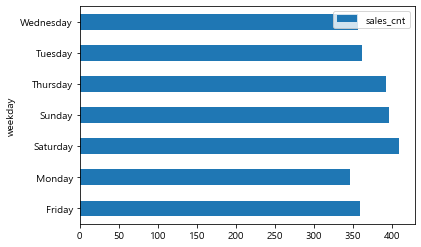

In [154]:
df4_train.pivot_table(index='weekday',values='sales_cnt').plot(kind='barh')

In [155]:
df4_train.drop(['datetime','year','product_cd','product_name','spot_pressure','sea_level_pressure','snowfall','group','sales_cnt','sell_price'],axis=1,inplace=True)

In [156]:
X4, y4 = df4_train.drop('log_sales_cnt', axis=1), df4_train['log_sales_cnt']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=42)

In [157]:
col = ['month','weekday','month_order','order_grp','product_grp','unit_price_group','holiday']

In [158]:
for i in col : 
    X4_train[i] = X4_train[i].astype('category')
    X4_test[i] = X4_test[i].astype('category') 

In [159]:
X4_train

,month,day,hour,minute,weekday,holiday,month_order,order_grp,exposure(min),mother_cd,product_grp,temp,rainfall,wind_speed,wind_direction,humidity,pressure,unit_price,unit_price_group,cpi,csi
3629,2,10,7,0,Sunday,1,중,시작,20.0,100369,의류,-9.0,0.0,1.1,50.0,39.0,1.2,59000.0,cheap,100.5,99.5
7733,3,24,8,20,Sunday,1,말,중간,20.0,100452,의류,0.3,0.0,1.4,290.0,48.0,3.0,49000.0,cheap,100.4,99.8
21605,8,8,8,20,Thursday,0,중,중간,20.0,100049,의류,26.4,0.0,0.6,20.0,83.0,28.4,199000.0,expensive,100.0,92.5
32024,11,26,6,20,Tuesday,0,말,중간,20.0,100288,속옷,1.8,0.0,2.1,70.0,76.0,5.3,69900.0,medium,100.2,101.0
9293,4,8,7,20,Monday,0,중,중간,20.0,100596,속옷,7.7,0.0,2.9,290.0,30.0,3.1,79000.0,medium,100.6,101.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20580,7,28,10,20,Sunday,1,말,중간,20.0,100412,의류,25.4,0.4,2.6,200.0,94.0,30.4,39000.0,cheap,100.6,95.9
18062,7,3,20,40,Wednesday,0,초,마지막,20.0,100618,속옷,25.0,0.0,1.4,200.0,69.0,21.8,69000.0,medium,100.6,95.9
18977,7,12,23,40,Friday,0,중,마지막,20.0,100598,속옷,22.8,0.0,1.6,250.0,72.0,19.9,59000.0,cheap,100.6,95.9
2898,2,2,15,40,Saturday,1,초,마지막,20.0,100606,속옷,4.5,0.0,1.0,70.0,51.0,4.3,119000.0,expensive,100.5,99.5


In [160]:
def model4_mape(num_leaves, learning_rate, n_estimators, max_depth, min_child_samples):
    model4 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = int(num_leaves), 
                              learning_rate = learning_rate,
                              n_estimators = int(n_estimators), 
                              max_depth = int(max_depth),
                              min_child_samples = int(min_child_samples)
                              )
    model4.fit(X4_train, y4_train)
    y4_pred = model4.predict(X4_test)
    mape = mean_absolute_percentage_error(np.exp(y4_test), np.exp(y4_pred))
    return -mape

pbounds4 = {'num_leaves': (2, 60), 
           'learning_rate': (0.05, 0.15),
          'n_estimators': (500, 1500),
            'max_depth' : (1,50),
            'min_child_samples' : (1,50) 
           }

In [161]:
model4 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = 29,
                              learning_rate = 0.13609953538724062,
                              n_estimators = 550, 
                              max_depth = 4,
                              min_child_samples = 8
                              )
model4.fit(X4_train, y4_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMRegressor(boosting='gbdt', learning_rate=0.13609953538724062, max_depth=4,
              min_child_samples=8, n_estimators=550, num_leaves=29,
              objective='regression')

In [166]:
def model4_mape(num_leaves, learning_rate, n_estimators, max_depth, min_child_samples):
    model4 = lgb.LGBMRegressor(objective = 'regression', 
                              boosting = 'gbdt',
                              num_leaves = int(num_leaves), 
                              learning_rate = learning_rate,
                              n_estimators = int(n_estimators), 
                              max_depth = int(max_depth),
                              min_child_samples = int(min_child_samples)
                              )
    model4.fit(X4_train, y4_train)
    y4_pred = model4.predict(X4_test)
    mape = mean_absolute_percentage_error(np.exp(y4_test), np.exp(y4_pred))
    return -mape

pbounds4 = {'num_leaves': (2, 50), 
           'learning_rate': (0.05, 0.15),
          'n_estimators': (500, 1500),
            'max_depth' : (1,50),
            'min_child_samples' : (1,50)
           }

In [167]:
bayesmodel4 = BayesianOptimization(f = model4_mape, pbounds = pbounds4, verbose = 2, random_state = 3)
bayesmodel4.maximize(init_points=2, n_iter = 100)

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  1        | -60.91    |  0.1051   |  35.7     |  15.25    |  1.011e+0 |  44.86    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  2        | -53.08    |  0.1396   |  7.154    |  11.15    |  551.5    |  23.16    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  3        | -50.04    |  0.06973  |  4.886    |  10.81    |  547.9    |  29.2     |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  4        | -50.67    |  0.1184   |  5.811    |  18.17    |  537.0    |  36.85    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_

|  32       | -54.32    |  0.07179  |  3.379    |  5.636    |  555.6    |  48.16    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  33       | -73.39    |  0.1388   |  1.3      |  2.18     |  560.9    |  47.46    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  34       | -58.47    |  0.1476   |  7.259    |  5.645    |  556.3    |  36.16    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  35       | -51.62    |  0.05713  |  8.011    |  16.24    |  555.9    |  43.63    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  36       | -53.72    |  0.1273   |  7.175    |  17.44    |  544.3    |  32.07    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  37       | -56.07    |  0.1

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  64       | -52.26    |  0.1496   |  15.2     |  20.85    |  560.4    |  19.55    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  65       | -49.41    |  0.07986  |  23.71    |  14.45    |  548.1    |  18.9     |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  66       | -53.35    |  0.15     |  21.91    |  15.74    |  560.0    |  19.59    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  67       | -49.45    |  0.1138   |  20.43    |  16.36    |  553.6    |  12.43    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  68       | -49.56    |  0.1357   |  18.41    |  14.29    |  549.6    |  13.78    |
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  97       | -50.95    |  0.05492  |  15.92    |  41.61    |  560.8    |  17.13    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  98       | -49.87    |  0.1281   |  9.95     |  39.91    |  557.5    |  11.39    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  99       | -50.02    |  0.08216  |  7.812    |  42.09    |  560.7    |  21.39    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  100      | -49.56    |  0.1008   |  5.138    |  39.07    |  564.8    |  16.85    |
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
|  101      | -51.44    |  0.05     |  8.378    |  45.41    |  563.1    |  14.09    |
[LightGBM] [Warning] boosting 

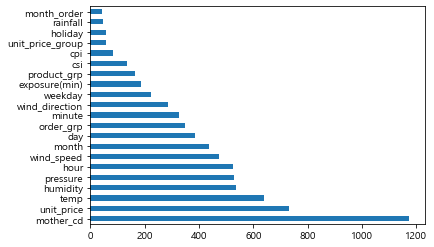

In [162]:
feat_importances = pd.Series(model4.feature_importances_, index=X4_train.columns)
feat_importances.sort_values(ascending = False).plot(kind='barh')

In [163]:
y4_pred = model4.predict(X4_test)
print ("MSE :", metrics.mean_squared_error(np.exp(y4_test), np.exp(y4_pred)))
print("R squared :", metrics.r2_score(np.exp(y4_test), np.exp(y4_pred)))
print(mean_absolute_percentage_error(np.exp(y4_test), np.exp(y4_pred)))

MSE : 22537.095857267766
R squared : 0.8051548986978219
49.23335620514385


In [164]:
y4_train_pred = model4.predict(X4_train)
print ("MSE :", metrics.mean_squared_error(np.exp(y4_train), np.exp(y4_train_pred)))
print("R squared :", metrics.r2_score(np.exp(y4_train), np.exp(y4_train_pred)))
print(mean_absolute_percentage_error(np.exp(y4_train), np.exp(y4_train_pred)))

MSE : 18634.26905215779
R squared : 0.8603324039243598
30.696630919755524


In [60]:
print(mean_absolute_percentage_error(np.exp(y1_test), np.exp(y1_pred)))
print(mean_absolute_percentage_error(np.exp(y2_test), np.exp(y2_pred)))
print(mean_absolute_percentage_error(np.exp(y3_test), np.exp(y3_pred)))
print(mean_absolute_percentage_error(np.exp(y4_test), np.exp(y4_pred)))


a = mean_absolute_percentage_error(np.exp(y1_test), np.exp(y1_pred))
b = mean_absolute_percentage_error(np.exp(y2_test), np.exp(y2_pred))
c = mean_absolute_percentage_error(np.exp(y3_test), np.exp(y3_pred))
d = mean_absolute_percentage_error(np.exp(y4_test), np.exp(y4_pred))
(len(y1_test)*a + len(y2_test)*b + len(y3_test)*c + len(y4_test)*d) / (len(y1_test)+len(y2_test)+len(y3_test)+len(y4_test))

48.304920032120016
26.045550434883708
37.223523321693044
45.11408225137925


40.08373151820037

## Prediction

학습된 모델을 그룹별로 `df_test`에 적용, 예측, csv로 저장

In [61]:
g1_test, g2_test, g3_test, g4_test = Spliting.return_g(df_test)

In [62]:
month_list = [1,2,3,4,5,8,9,10,11,12]
for i in month_list:
    g1_test[f'month_{i}'] = 0
    g2_test[f'month_{i}'] = 0    
    g3_test[f'month_{i}'] = 0    
    g4_test[f'month_{i}'] = 0    

In [63]:
g1_test = g1_test[g1.columns]
g2_test = g2_test[g2.columns]
g3_test = g3_test[g3.columns]
g4_test = g4_test[g4.columns]

In [64]:
g1_test = g1_test.drop('log_sales_cnt', axis=1)
g2_test = g2_test.drop('log_sales_cnt', axis=1)
g3_test = g3_test.drop('log_sales_cnt', axis=1)
g4_test = g4_test.drop('log_sales_cnt', axis=1)

In [65]:
g1_pred = pipe_model1.predict(g1_test)
g2_pred = pipe_model2.predict(g2_test)
g3_pred = pipe_model3.predict(g3_test)
g4_pred = pipe_model4.predict(g4_test)

NameError: name 'pipe_model1' is not defined

In [ ]:
g1_test['answer'] = np.exp(g1_pred)
g2_test['answer'] = np.exp(g2_pred)
g3_test['answer'] = np.exp(g3_pred)
g4_test['answer'] = np.exp(g4_pred)

In [ ]:
final_answer = pd.concat([g1_test, g2_test, g3_test, g4_test]).sort_index().answer

In [ ]:
df_test['answer'] = final_answer

In [ ]:
df_test[['datetime', 'exposure(min)', 'mother_cd', 'product_cd', 'product_name', 'product_grp', 'unit_price', 'answer']].head(50)